<a href="https://colab.research.google.com/github/Karima-mtq/Basemap/blob/main/EOF_SST_Free.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [126]:
!pip install netCDF4
!pip install eofs
!pip install Basemap

In [127]:
%matplotlib inline
import xarray as xr
import os
from scipy import signal
from netCDF4 import Dataset
from mpl_toolkits.basemap import Basemap
from eofs.standard import Eof
from netCDF4 import num2date
import numpy as np
import numpy.polynomial.polynomial as poly
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
import glob

**Get the data if not available**


In [ ]:
#!apt-get install -y wget

 #Download all .nc files from the folder
!wget -r -np -nH --cut-dirs=5 -A "*Free_ens.micom.hm.20*.nc" \
    -P /content/drive/MyDrive/data_zip/FREE/OCN \
    https://ns9039k.web.sigma2.no/datapeak/lgarcia/initializations/Free/reana/ocn/

--2025-10-09 13:09:57--  https://ns9039k.web.sigma2.no/datapeak/lgarcia/initializations/Free/reana/ocn/
Resolving ns9039k.web.sigma2.no (ns9039k.web.sigma2.no)... 158.36.102.245
Connecting to ns9039k.web.sigma2.no (ns9039k.web.sigma2.no)|158.36.102.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘/content/drive/MyDrive/data_zip/FREE/OCN/ocn/index.html.tmp’

ocn/index.html.tmp      [  <=>               ] 114.65K   311KB/s    in 0.4s    

2025-10-09 13:09:58 (311 KB/s) - ‘/content/drive/MyDrive/data_zip/FREE/OCN/ocn/index.html.tmp’ saved [117398]

Loading robots.txt; please ignore errors.
--2025-10-09 13:09:59--  https://ns9039k.web.sigma2.no/robots.txt
Reusing existing connection to ns9039k.web.sigma2.no:443.
HTTP request sent, awaiting response... 404 Not Found
2025-10-09 13:09:59 ERROR 404: Not Found.

Removing /content/drive/MyDrive/data_zip/FREE/OCN/ocn/index.html.tmp since it should be rejected.

--2025-10-09 13:09:59

In [ ]:
# Create the target folder if it doesn't exist
#!mkdir -p "/content/drive/MyDrive/data_zip/FREE/OCN"

# Download the grid file into that folder
!wget -O "/content/drive/MyDrive/data_zip/FREE/OCN/grid_tnx1v4_20170622.nc" \
"https://ns9560k.web.sigma2.no/datapeak/inputdata/ocn/blom/grid/grid_tnx1v4_20170622.nc"

# List files to confirm

--2025-10-09 11:18:24--  https://ns9560k.web.sigma2.no/datapeak/inputdata/ocn/blom/grid/grid_tnx1v4_20170622.nc
Resolving ns9560k.web.sigma2.no (ns9560k.web.sigma2.no)... 158.36.102.245
Connecting to ns9560k.web.sigma2.no (ns9560k.web.sigma2.no)|158.36.102.245|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75162156 (72M) [application/x-netcdf]
Saving to: ‘/content/drive/MyDrive/data_zip/FREE/OCN/grid_tnx1v4_20170622.nc’

         /content/d   0%[                    ]  26.38K   108KB/s               ^C


In [ ]:
#!mkdir -p "/content/drive/MyDrive/data_zip/FREE/OCN/grid"

In [ ]:
!mv "/content/drive/MyDrive/data_zip/FREE/OCN/grid_tnx1v4_20170622.nc" "/content/drive/MyDrive/data_zip/FREE/OCN/grid"

In [ ]:
import xarray as xr

grid = xr.open_dataset("/content/drive/MyDrive/data_zip/FREE/OCN/grid/grid_tnx1v4_20170622.nc")
print(grid)


<xarray.Dataset> Size: 75MB
Dimensions:  (y: 385, x: 360, nv: 4, pcomp: 86708, qcomp: 88239, ucomp: 88642,
              vcomp: 87942)
Coordinates:
  * pcomp    (pcomp) int32 347kB 3667 3668 3670 3671 ... 138559 138560 138561
  * qcomp    (qcomp) int32 353kB 3668 3671 3672 3673 ... 138560 138561 138562
  * ucomp    (ucomp) int32 355kB 3667 3668 3669 3670 ... 138560 138561 138562
  * vcomp    (vcomp) int32 352kB 3667 3668 3670 3671 ... 138560 138561 138562
Dimensions without coordinates: y, x, nv
Data variables: (12/53)
    insw     (y, x) int32 554kB ...
    jnsw     (y, x) int32 554kB ...
    ins      (y, x) int32 554kB ...
    jns      (y, x) int32 554kB ...
    inse     (y, x) int32 554kB ...
    jnse     (y, x) int32 554kB ...
    ...       ...
    vdepth   (y, x) float64 1MB ...
    pmask    (y, x) int32 554kB ...
    umask    (y, x) int32 554kB ...
    vmask    (y, x) int32 554kB ...
    qmask    (y, x) int32 554kB ...
    cplmask  (y, x) int32 554kB ...
Attributes:
    nreg:    

**Load FREE SST files and concatenate**

In [128]:
all_files = sorted(glob.glob("/content/drive/MyDrive/data_zip/FREE/OCN/ocn/Free_ens.micom.hm.*.nc"))
files = [f for f in all_files if int(f.split('.')[-2].replace('-', '')) <= 201012]
# Use netCDF4 engine explicitly
ds_all = xr.open_mfdataset(files, combine="by_coords", engine="netcdf4")
sst = ds_all['sst']
print(sst.shape)
print(ds_all)

/tmp/ipython-input-1324298439.py:4: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds_all = xr.open_mfdataset(files, combine="by_coords", engine="netcdf4")


(372, 384, 320)
<xarray.Dataset> Size: 52GB
Dimensions:     (time: 372, depth: 70, bounds: 2, y: 384, x: 320)
Coordinates:
  * time        (time) object 3kB 1980-01-17 00:00:00 ... 2010-12-17 00:00:00
  * depth       (depth) float64 560B 0.0 5.0 10.0 ... 6.25e+03 6.5e+03 6.75e+03
Dimensions without coordinates: bounds, y, x
Data variables:
    depth_bnds  (time, depth, bounds) float64 417kB dask.array<chunksize=(1, 70, 2), meta=np.ndarray>
    salnlvl     (time, depth, y, x) float64 26GB dask.array<chunksize=(1, 35, 192, 160), meta=np.ndarray>
    sst         (time, y, x) float64 366MB dask.array<chunksize=(1, 384, 320), meta=np.ndarray>
    templvl     (time, depth, y, x) float64 26GB dask.array<chunksize=(1, 35, 192, 160), meta=np.ndarray>
Attributes:
    history:  Tue Sep  5 16:30:24 2023: ncks -O -v sst,templvl,salnlvl,depth_...
    NCO:      netCDF Operators version 5.0.3 (Homepage = http://nco.sf.net, C...


**Load FREE SST files and concatenate**

In [129]:
# Extract the time values (cftime objects)
time_vals = ds_all['time'].values

# Get min and max years
year1 = min(t.year for t in time_vals)
year2 = max(t.year for t in time_vals)

print("Year range:", year1, "-", year2)


Year range: 1980 - 2010


**Load grid mask**

In [130]:
sst_data = sst.values



In [131]:
nt,nlat,nlon = sst.shape
startY = year1
endY   = year2
ndy    = year2-year1+1
ny = nt/ndy
print(startY, endY, ndy, ny)

1980 2010 31 12.0


In [132]:
import numpy as np
import numpy.polynomial.polynomial as poly

# Dimensions
nt, nlat, nlon = sst_data.shape

sst_detrend = np.empty(sst_data.shape)
sst_coeffs  = np.empty((2, nlat, nlon))
sst_detrend[:,:,:] = np.nan

x = np.linspace(1, nt, nt)

for i in range(nlat):
    for j in range(nlon):
        y = sst_data[:, i, j]   # <-- use raw numpy array
        if np.all(np.isnan(y)):
            continue
        b = ~np.isnan(y)
        coefs = poly.polyfit(x[b], y[b], 1)
        sst_coeffs[0, i, j] = coefs[0]
        sst_coeffs[1, i, j] = coefs[1]
        ffit = poly.polyval(x[b], coefs)
        sst_detrend[b, i, j] = y[b] - ffit


In [133]:
sst_all = sst_detrend.reshape((ndy,int(ny),nlat,nlon), order='F').transpose((1,0,2,3)) # year, 36, lat, lon
sst_season = np.mean(sst_all, axis=0)
sst_diff = sst_all - sst_season
#mask_4d = np.broadcast_to((pmask_trimmed==0), sst_all.shape)
#sst_diff = np.ma.masked_array(sst_diff, mask=mask_4d) # have to do this, or fill in zeros in sst_diff.
sst_final = sst_diff.transpose((1,0,2,3)).reshape((ndy*int(ny),nlat,nlon), order='F')


In [136]:
lat = np.linspace(-90, 90, nlat)  # if first row is South
lon = np.linspace(-180, 180, nlon)

In [137]:
coslat = np.cos(np.deg2rad(lat))
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(sst_final, weights=wgts)

print(coslat.shape)
print(wgts.shape)

(384,)
(384, 1)


In [138]:
eof1 = solver.eofs(neofs=10)
pc1  = solver.pcs(npcs=10, pcscaling=0)
varfrac = solver.varianceFraction()
lambdas = solver.eigenvalues()

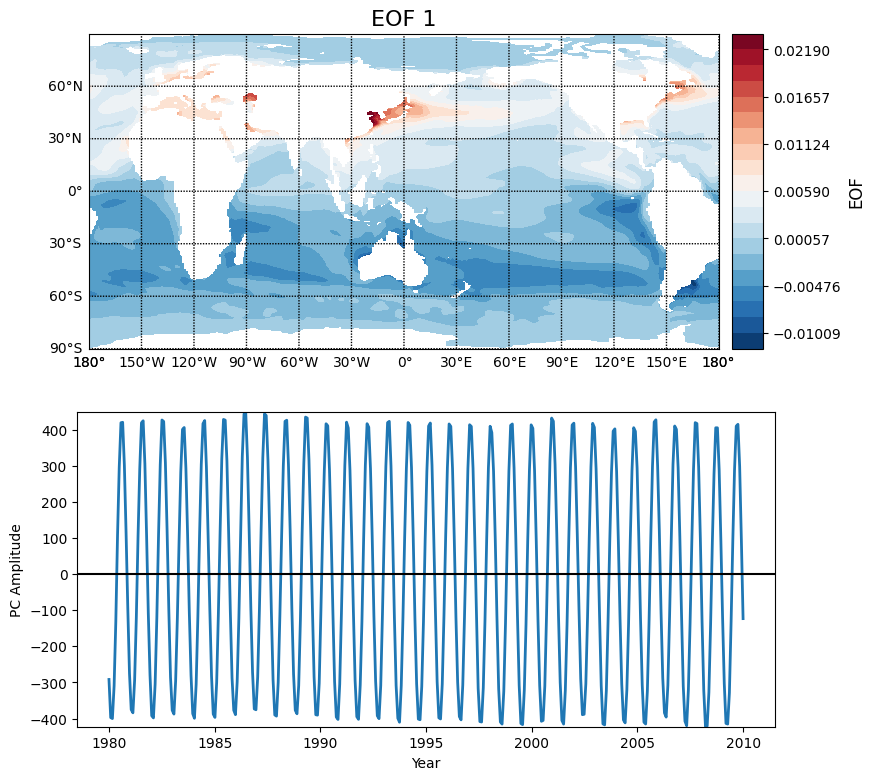

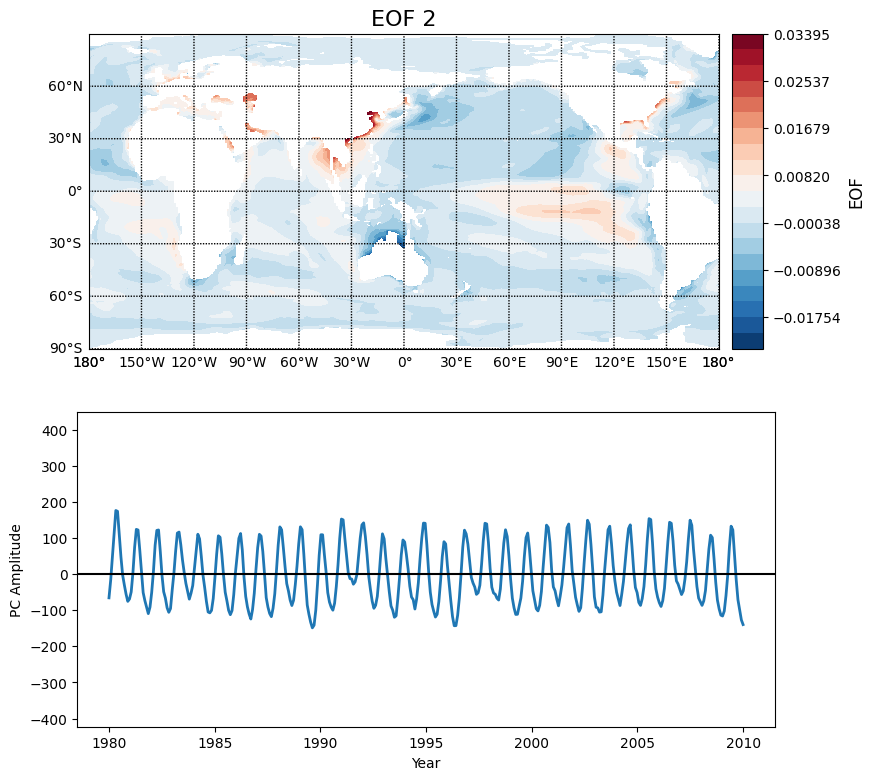

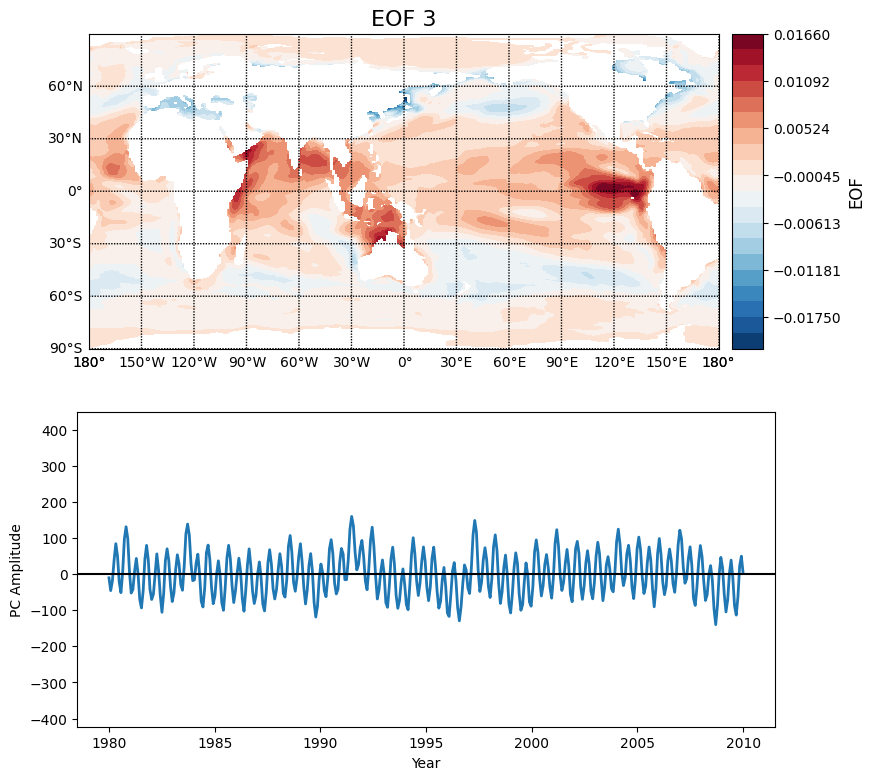

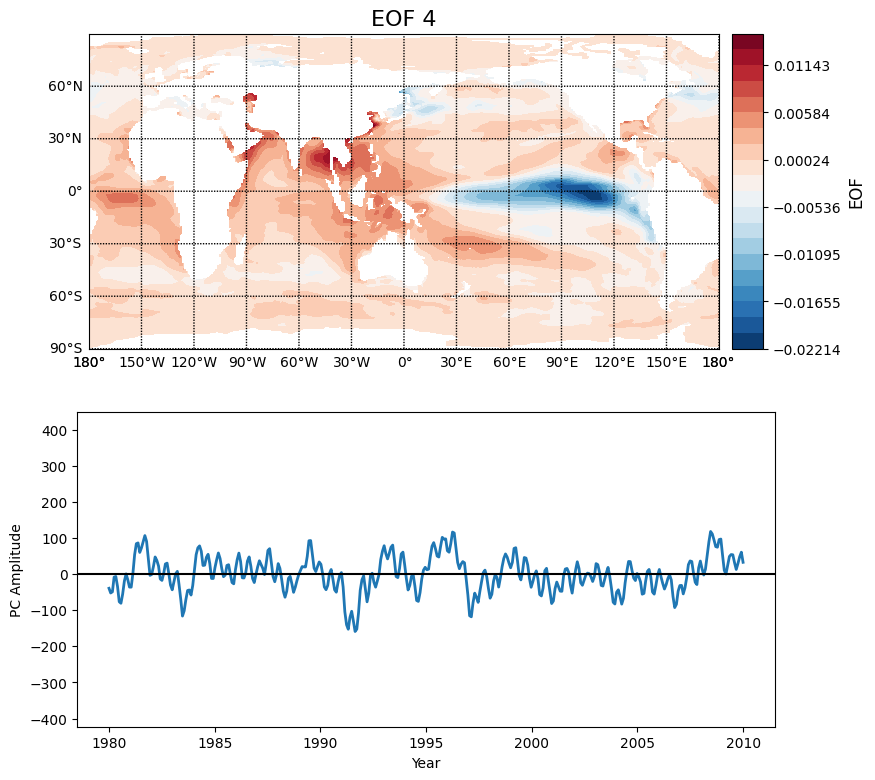

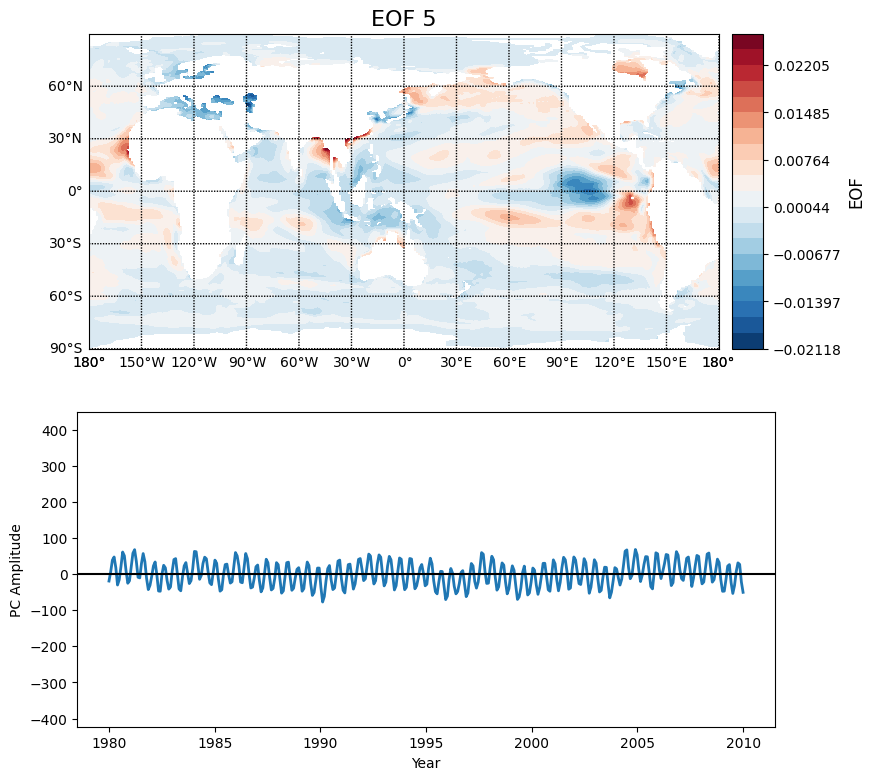

In [139]:
parallels = np.arange(-90,90,30.)
meridians = np.arange(-180,180,30)

for i in range(0,5):
    fig = plt.figure(figsize=(9,9))
    plt.subplot(211)

    m = Basemap(projection='cyl', llcrnrlon=min(lon), llcrnrlat=min(lat), urcrnrlon=max(lon), urcrnrlat=max(lat))
    x, y = m(*np.meshgrid(lon, lat))
    field = eof1[i, :, :].squeeze()

    # Remove NaNs before finding min/max
    valid = np.isfinite(field)
    vmin = field[valid].min()
    vmax = field[valid].max()

    clevs = np.linspace(vmin, vmax, 21)
    cs = m.contourf(x, y, field, clevs, cmap=plt.cm.RdBu_r)
    #m.drawcoastlines()
    m.drawparallels(parallels, labels=[1,0,0,0])
    m.drawmeridians(meridians, labels=[1,0,0,1])

    cb = m.colorbar(cs, 'right', size='5%', pad='2%')
    cb.set_label('EOF', fontsize=12)
    plt.title('EOF ' + str(i+1), fontsize=16)

    plt.subplot(212)
    #days = np.linspace(year1,year2,int(nt))
    days = np.linspace(year1, year2, int(nt))
    plt.plot(days, pc1[:,i], linewidth=2)
    plt.axhline(0, color='k')
    plt.xlabel('Year')
    plt.ylabel('PC Amplitude')
    plt.ylim(np.min(pc1.squeeze()), np.max(pc1.squeeze()))

    #plt.savefig('EOF' + str(i+1)+'.png')
    #plt.savefig('EOF' + str(i+1)+'.pdf')

(2.1611537015034157e-33, 0.7958194221753891)

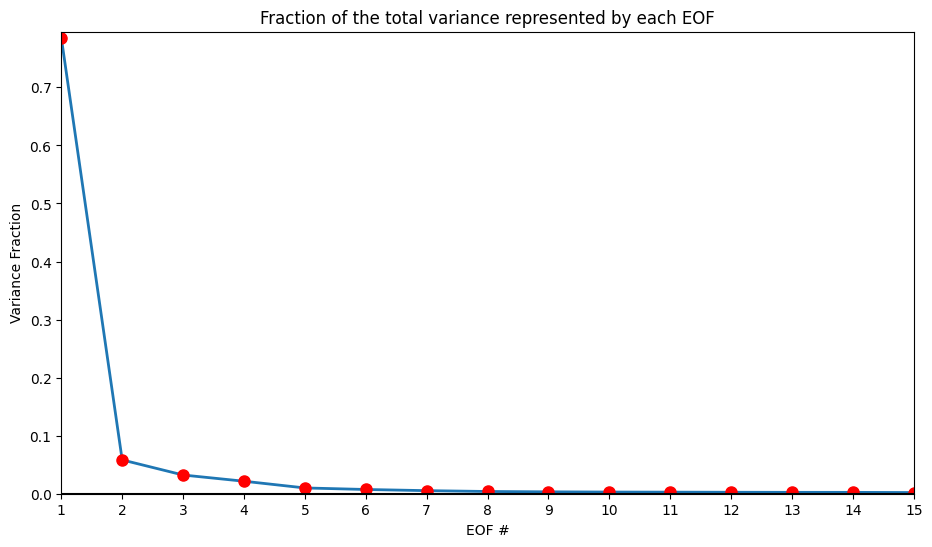

In [140]:
plt.figure(figsize=(11,6))
eof_num = range(1, 16)
plt.plot(eof_num, varfrac[0:15], linewidth=2)
plt.plot(eof_num, varfrac[0:15], linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 16))
plt.title('Fraction of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Fraction')
plt.xlim(1, 15)
plt.ylim(np.min(varfrac), np.max(varfrac)+0.01)
#plt.savefig('ScreePlot-Explained-Variance.png')
#plt.savefig('ScreePlot-Explained-Variance.pdf')


In [141]:
sum = 0
for i in range(0, 5):
    sum = sum + round(varfrac[i]*100)
    print("EOF", i, "explain", round(varfrac[i]*100), "%",", variance Cumulée :", sum, "%")

EOF 0 explain 79 % , variance Cumulée : 79 %
EOF 1 explain 6 % , variance Cumulée : 85 %
EOF 2 explain 3 % , variance Cumulée : 88 %
EOF 3 explain 2 % , variance Cumulée : 90 %
EOF 4 explain 1 % , variance Cumulée : 91 %
